In [1]:
import pandas as pd

housing = pd.read_csv(
    "G:/jupyter_notebook/Linear Regression/datasets/housing/housing.csv")

[17606 18632 14650 ... 13908 11159 15775]
[ 5241 10970 20351 ...  4019 12107  2398]


3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

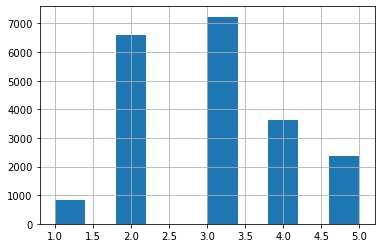

In [3]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3., 4.5, 6., np.inf],
                              labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    print(train_index) 
    print(test_index)
    strat_train_set = housing.loc[train_index]
    strat_test_set  = housing.loc[test_index]
strat_test_set["income_cat"].value_counts()/len(strat_test_set)